In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as vdatasets
import torchvision.utils as vutils
import random
from tensorboardX import SummaryWriter
import os
torch.manual_seed(1)

DATA_PATH = os.environ['DATA_PATH']
USE_CUDA = torch.cuda.is_available()

import matplotlib.pyplot as plt
%matplotlib inline

### CIFAR-10

In [3]:
train_dataset = vdatasets.CIFAR10(root=DATA_PATH+'CIFAR10/',
                               train=True,
                               transform=transforms.Compose([
                                                        transforms.RandomHorizontalFlip(),
                                                        transforms.ToTensor(),
                                                        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                                                          std=[0.247, 0.243, 0.261])]),
                               download=True)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

test_dataset = vdatasets.CIFAR10(root=DATA_PATH+'CIFAR10/',
                               train=False, 
                               transform=transforms.Compose([transforms.ToTensor(),
                                                            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                                                              std=[0.247, 0.243, 0.261])]),
                               download=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(train_dataset[0][0].size())

torch.Size([3, 32, 32])


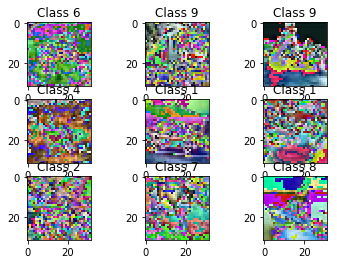

In [4]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_dataset[i][0].transpose(0,1).transpose(1,2).numpy(),interpolation=None)
    plt.title("Class {}".format(train_dataset[i][1]))

## TODO 

- VGG16의 FC layer 전까지를 작성하시오(Feature extraction)
- Conv layer 뒤에는 batch normalization을 적용하시오

In [5]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        
        self.fc = nn.Linear(512,10)
         
    def forward(self,inputs):
        outputs = self.conv_layer(inputs)
        return self.fc(outputs.view(outputs.size(0),-1))
        

In [6]:
EPOCH=40
LR=0.001
BATCH_SIZE=64

model = VGG()
if USE_CUDA:
    model = model.cuda()
loss_function = nn.CrossEntropyLoss() # 소프트맥스 함수 포함하고 있음
optimizer = optim.Adam(model.parameters(), lr=LR)

In [7]:
model.train()
for epoch in range(EPOCH):
    losses=[]
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = Variable(inputs), Variable(targets)
        if USE_CUDA:
            inputs,targets = inputs.cuda(),targets.cuda()
        model.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.data[0])
        if i % 300 == 0:
            print("[%d/%d] [%03d/%d] mean_loss : %.3f" % (epoch,EPOCH,i,len(train_loader),np.mean(losses)))
            losses=[]

[0/40] [000/782] mean_loss : 2.389
[0/40] [300/782] mean_loss : 1.777
[0/40] [600/782] mean_loss : 1.341
[1/40] [000/782] mean_loss : 1.137
[1/40] [300/782] mean_loss : 1.002
[1/40] [600/782] mean_loss : 0.919
[2/40] [000/782] mean_loss : 0.810
[2/40] [300/782] mean_loss : 0.761
[2/40] [600/782] mean_loss : 0.740
[3/40] [000/782] mean_loss : 0.499
[3/40] [300/782] mean_loss : 0.626
[3/40] [600/782] mean_loss : 0.608
[4/40] [000/782] mean_loss : 0.853
[4/40] [300/782] mean_loss : 0.535
[4/40] [600/782] mean_loss : 0.527
[5/40] [000/782] mean_loss : 0.438
[5/40] [300/782] mean_loss : 0.457
[5/40] [600/782] mean_loss : 0.477
[6/40] [000/782] mean_loss : 0.506
[6/40] [300/782] mean_loss : 0.418
[6/40] [600/782] mean_loss : 0.404
[7/40] [000/782] mean_loss : 0.204
[7/40] [300/782] mean_loss : 0.360
[7/40] [600/782] mean_loss : 0.353
[8/40] [000/782] mean_loss : 0.403
[8/40] [300/782] mean_loss : 0.319
[8/40] [600/782] mean_loss : 0.315
[9/40] [000/782] mean_loss : 0.316
[9/40] [300/782] mea

In [8]:
model.eval()
num_equal=0
for i, (inputs, targets) in enumerate(test_loader):
    inputs, targets = Variable(inputs), Variable(targets)
    if USE_CUDA:
        inputs, targets = inputs.cuda(), targets.cuda()
    model.zero_grad()
    outputs = model(inputs)
    
    outputs = outputs.max(1)[1] # argmax
    num_equal += torch.eq(outputs,targets).sum().data[0]
    
    
print("Accuracy : " ,num_equal/len(test_dataset))

Accuracy :  0.8837
